In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [31]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [32]:
times = len(train_data) / len(test_data)
print('Train data length is', '%.2f' % times, 'times the length of test data.')
train_percent = (100 / (times + 1)) * times
test_percent = 100 - train_percent
print('This means that the data has', '%.0f' % train_percent + '/' + '%.0f' % test_percent, 'train/test split.')

Train data length is 4.00 times the length of test data.
This means that the data has 80/20 train/test split.


#### EDA and Feature Engineering

In [33]:
train_data.head(2)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33


In [34]:
test_data.head(2)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City
0,0x2318,COIMBRES13DEL01,NaN,NaN,11.003669,76.976494,11.043669,77.016494,30-03-2022,NaN,15:05:00,conditions NaN,NaN,3,Drinks,electric_scooter,1,No,Metropolitian
1,0x3474,BANGRES15DEL01,28,4.6,12.975377,77.696664,13.085377,77.806664,29-03-2022,20:30:00,20:35:00,conditions Windy,Jam,0,Snack,motorcycle,1,No,Metropolitian


In [35]:
# the NaN values in the dataset currently are strings, so let's replace them with the actual np.nan value
train_data = train_data.replace('NaN', np.nan, regex=True)

In [36]:
# remove useless columns
useless_cols = ['ID', 'Delivery_person_ID', 'Order_Date', 'Vehicle_condition', 'Time_Order_picked']
train_data.drop(useless_cols, axis=1, inplace=True)

In [37]:
train_data.head(2)

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Weatherconditions,Road_traffic_density,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,37,4.9,22.745049,75.892471,22.765049,75.912471,11:30:00,conditions Sunny,High,Snack,motorcycle,0,No,Urban,(min) 24
1,34,4.5,12.913041,77.683237,13.043041,77.813237,19:45:00,conditions Stormy,Jam,Snack,scooter,1,No,Metropolitian,(min) 33


#### Weather Conditions

In [38]:
print('Old Weather Conditions:', train_data.Weatherconditions.unique())

# we can see that all the weather conditions contain "conditions" in the name so we can remove that
# we can then one hot encode the weather conditions
train_data['Weatherconditions'] = train_data['Weatherconditions'].str.replace("conditions ", "")
print('New Weather Conditions', train_data.Weatherconditions.unique())

Old Weather Conditions: ['conditions Sunny' 'conditions Stormy' 'conditions Sandstorms'
 'conditions Cloudy' 'conditions Fog' 'conditions Windy' nan]
New Weather Conditions ['Sunny' 'Stormy' 'Sandstorms' 'Cloudy' 'Fog' 'Windy' nan]


In [39]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
weather_arr = ohe.fit_transform(train_data[['Weatherconditions']]).toarray()
weather_labels = ohe.categories_[0]
weather = pd.DataFrame(weather_arr, columns=weather_labels)
weather = weather.loc[:, weather.columns.notna()]
weather.head(2)

,Cloudy,Fog,Sandstorms,Stormy,Sunny,Windy
0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0


In [40]:
train_data = pd.concat([train_data, weather], axis=1)
train_data.drop('Weatherconditions', axis=1, inplace=True)

In [41]:
train_data.head(2)

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Road_traffic_density,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Cloudy,Fog,Sandstorms,Stormy,Sunny,Windy
0,37,4.9,22.745049,75.892471,22.765049,75.912471,11:30:00,High,Snack,motorcycle,0,No,Urban,(min) 24,0.0,0.0,0.0,0.0,1.0,0.0
1,34,4.5,12.913041,77.683237,13.043041,77.813237,19:45:00,Jam,Snack,scooter,1,No,Metropolitian,(min) 33,0.0,0.0,0.0,1.0,0.0,0.0


#### Traffic Conditions

In [42]:
print('Traffic:', train_data.Road_traffic_density.unique())
train_data['Road_traffic_density'] = train_data['Road_traffic_density'].str.replace(" ", "")
print('Traffic:', train_data.Road_traffic_density.unique())

Traffic: ['High ' 'Jam ' 'Low ' 'Medium ' nan]
Traffic: ['High' 'Jam' 'Low' 'Medium' nan]


In [43]:
# use ordinal encoder
from sklearn.preprocessing import OrdinalEncoder


# save to later check if the same rows have NaN
orig_ind = np.where(train_data['Road_traffic_density'].isna())[0]

oe = OrdinalEncoder(categories=[['Low', 'Medium', 'High', 'Jam']])
train_data.loc[train_data.Road_traffic_density.notna(), ['Road_traffic_density']] = oe.fit_transform(train_data['Road_traffic_density'].dropna().values.reshape(-1,1))

# show that our ordinal encoding did not change the NaN values
new_ind = np.where(train_data['Road_traffic_density'].isna())[0]
print((orig_ind == new_ind).all())

# we can also map the values ourselves instead of using the ordinal encoder
# Even though mapping is much easier here, I wanted to use OrdinalEncoder for this task because it's much more scalable

# traffic_map = {'Low': 0, 'Medium': 1, 'High': 2, 'Jam': 3}
# train_data['Road_traffic_density'] = train_data['Road_traffic_density'].map(traffic_map).fillna(train_data['Road_traffic_density'])

True


In [44]:
train_data.head(2)

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Road_traffic_density,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Cloudy,Fog,Sandstorms,Stormy,Sunny,Windy
0,37,4.9,22.745049,75.892471,22.765049,75.912471,11:30:00,2.0,Snack,motorcycle,0,No,Urban,(min) 24,0.0,0.0,0.0,0.0,1.0,0.0
1,34,4.5,12.913041,77.683237,13.043041,77.813237,19:45:00,3.0,Snack,scooter,1,No,Metropolitian,(min) 33,0.0,0.0,0.0,1.0,0.0,0.0


In [45]:
train_data['Time_taken(min)'] = train_data['Time_taken(min)'].str.replace("(min) ", "")

In [46]:
# convert columns to floats, ignore any errors
train_data = train_data.apply(pd.to_numeric, errors='ignore')

#### Age

In [47]:
train_data.Delivery_person_Age.value_counts()

Delivery_person_Age
35.0    2262
36.0    2260
37.0    2227
30.0    2226
38.0    2219
24.0    2210
32.0    2202
22.0    2196
29.0    2191
33.0    2187
28.0    2179
25.0    2174
34.0    2166
26.0    2159
21.0    2153
27.0    2150
39.0    2144
20.0    2136
31.0    2120
23.0    2087
50.0      53
15.0      38
Name: count, dtype: int64

Since ages 50 and 15 are significantly different from the rest, I'm going to see if I can engineer those two age groups myself.

#### Plot Age vs Time Taken

In [48]:
unique_age = train_data['Delivery_person_Age'].unique()

In [49]:
unique_age

array([37., 34., 23., 38., 32., 22., 33., 35., 36., 21., 24., 29., 25.,
       31., 27., 26., 20., nan, 28., 39., 30., 15., 50.])

In [50]:
mean_time_age = train_data.groupby('Delivery_person_Age', as_index=False)['Time_taken(min)'].mean()

In [51]:
mean_time_age

,Delivery_person_Age,Time_taken(min)
0,15.0,26.000000
1,20.0,22.898876
2,21.0,22.908500
3,22.0,22.934426
4,23.0,23.197413
5,24.0,23.059729
6,25.0,22.819227
7,26.0,22.948124
8,27.0,23.053023
9,28.0,23.166590


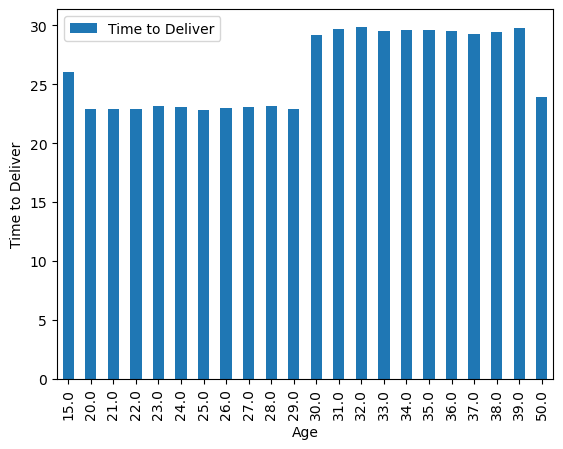

In [92]:
mean_time_plot = mean_time_age.plot(x='Delivery_person_Age', y='Time_taken(min)', kind='bar', label='Time to Deliver')
mean_time_plot.set_xlabel('Age')
mean_time_plot.set_ylabel('Time to Deliver');

We see here that delivery drivers of age 20 to 29 all take roughly the same time to deliver food, drivers of age 30 to 39 all take roughly the same time to deliver food and ages 15 and 50 have more unique values. Although the mean time to deliver for a 50 year old is only slightly above that of the highest mean amongst 20-29 year olds, we will leave 50 year olds in their own category since if we are thinking rationally, there shouldn't be any correlation between the speed of a 20-29 year old and a 50 year old.

In [53]:
train_data.loc[train_data['Delivery_person_Age'] == 50, 'Time_taken(min)'].mean()

23.943396226415093

In [54]:
train_data.loc[train_data['Delivery_person_Age'] == 15, 'Time_taken(min)'].mean()

26.0

In [55]:
train_data['Time_taken(min)'].mean()

26.29460662821047

In [56]:
train_data

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Road_traffic_density,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Cloudy,Fog,Sandstorms,Stormy,Sunny,Windy
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,11:30:00,2.0,Snack,motorcycle,0.0,No,Urban,24,0.0,0.0,0.0,0.0,1.0,0.0
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,19:45:00,3.0,Snack,scooter,1.0,No,Metropolitian,33,0.0,0.0,0.0,1.0,0.0,0.0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,08:30:00,0.0,Drinks,motorcycle,1.0,No,Urban,26,0.0,0.0,1.0,0.0,0.0,0.0
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,18:00:00,1.0,Buffet,motorcycle,1.0,No,Metropolitian,21,0.0,0.0,0.0,0.0,1.0,0.0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,13:30:00,2.0,Snack,scooter,1.0,No,Metropolitian,30,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45588,30.0,4.8,26.902328,75.794257,26.912328,75.804257,11:35:00,2.0,Meal,motorcycle,0.0,No,Metropolitian,32,0.0,0.0,0.0,0.0,0.0,1.0
45589,21.0,4.6,0.000000,0.000000,0.070000,0.070000,19:55:00,3.0,Buffet,motorcycle,1.0,No,Metropolitian,36,0.0,0.0,0.0,0.0,0.0,1.0
45590,30.0,4.9,13.022394,80.242439,13.052394,80.272439,23:50:00,0.0,Drinks,scooter,0.0,No,Metropolitian,16,1.0,0.0,0.0,0.0,0.0,0.0
45591,20.0,4.7,11.001753,76.986241,11.041753,77.026241,13:35:00,2.0,Snack,motorcycle,1.0,No,Metropolitian,26,1.0,0.0,0.0,0.0,0.0,0.0


#### Split training so we have validation data
I want a 10% validation data split of the whole dataset, so we will split the current training data into a 70/10 train/validation split which means that validation data makes up 12.5% ($10/80$) of the current training data.

In [57]:
from sklearn.model_selection import train_test_split

# train_data, valid_data = train_test_split(train_data, test_size=0.125, random_state=1)